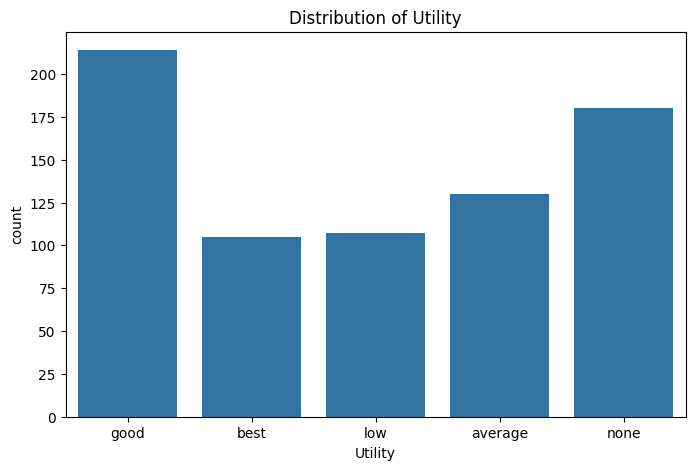

[WARNING] [2024-01-07 22:42:06,475:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-01-07 22:42:06,651:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-01-07 22:42:07,190:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-01-07 22:42:08,070:Client-EnsembleBuilder] No runs were available to build an ensemble from
auto-sklearn results:
  Dataset name: 4d9475c5-ad73-11ee-a233-3c2c30b32ecc
  Metric: accuracy
  Best validation score: 0.601227
  Number of target algorithm runs: 175
  Number of successful target algorithm runs: 118
  Number of crashed target algorithm runs: 51
  Number of target algorithms that exceeded the time limit: 2
  Number of target algorithms that exceeded the memory limit: 4

Error getting feature importances: All arrays must be of the same length
Accuracy: 0.638


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from autosklearn.classification import AutoSklearnClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
file_path = './dataset_194_eucalyptus.csv'
df = pd.read_csv(file_path)

# Visualize the distribution of the target variable
plt.figure(figsize=(8, 5))
sns.countplot(x='Utility', data=df)
plt.title('Distribution of Utility')
plt.show()

# Assuming 'Utility' is the target variable and other columns are features
X = df.drop('Utility', axis=1)  # Features
y = df['Utility']  # Target variable

# Convert target variable to numerical using LabelEncoder
y = LabelEncoder().fit_transform(y.astype('str'))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Preprocessing: Define the ColumnTransformer
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the AutoSklearnClassifier
model = AutoSklearnClassifier(time_left_for_this_task=5*60, per_run_time_limit=30, n_jobs=8)

# Create a pipeline with the preprocessor and the AutoSklearn model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', model)])

# Perform the search
pipeline.fit(X_train, y_train)

# Summarize
print(pipeline.named_steps['model'].sprint_statistics())

# Visualize the feature importance (if available)
try:
    importances = pipeline.named_steps['model'].get_models_with_weights()[1]
    feature_names = list(X.columns)
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.show()
except Exception as e:
    print(f"Error getting feature importances: {e}")

# Evaluate the best model
y_hat = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_hat)
print("Accuracy: %.3f" % acc)
